torch를 이용하여 MLP 모델을 구현했습니다. 또한 여러 종류의 optimizer, lr scheduler, regularization, dropout, batch normalization을 사용해보고 어떤 효과가 있는지 실험을 하며 비교해봤습니다. 

In [42]:
import os

import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

gpu가 없지만 있다고 가정하고 구현했습니다.

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Mnist 데이터 로드

datasets.MNIST()을 이용하여 mnist 데이터를 저장 후 로드합니다.

In [44]:
# 저장될 데이터 위치 지정
root = os.path.join(os.getcwd(), "data")
root

'/home/nackta/python_project/socar_bootcamp/data'

In [45]:
mnist_train = datasets.MNIST(
    root=root, 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    root=root, 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
) 

mnist train 데이터는 60000개, test 데이터는 10000개임을 알 수 있습니다.

In [46]:
print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/nackta/python_project/socar_bootcamp/data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/nackta/python_project/socar_bootcamp/data
    Split: Test
    StandardTransform
Transform: ToTensor()


mnist data에는 feature data와 label data가 tuple로 한 쌍으로 묶여져 있습니다.

feature data의 size는 (1x28x28)임을 알 수 있으며 매칭되는 label data로 숫자가 있습니다. 

In [47]:
sample_x, sample_y = mnist_train[0]
print(sample_x.shape)
print(sample_y)

torch.Size([1, 28, 28])
5


라벨 데이터의 범위는 0~9까지의 정수입니다.

In [48]:
mnist_train.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [49]:
def plot_mnist(data, figsize=(20, 10)):
  fig = plt.figure(figsize=figsize)
  for i in range(18):
    img = data[i][0]
    ax = fig.add_subplot(3, 6, i+1) # 3x6, i+1번째 자리에 plot
    ax.imshow(img.reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {data[i][1]}")
  fig.show()
  pass

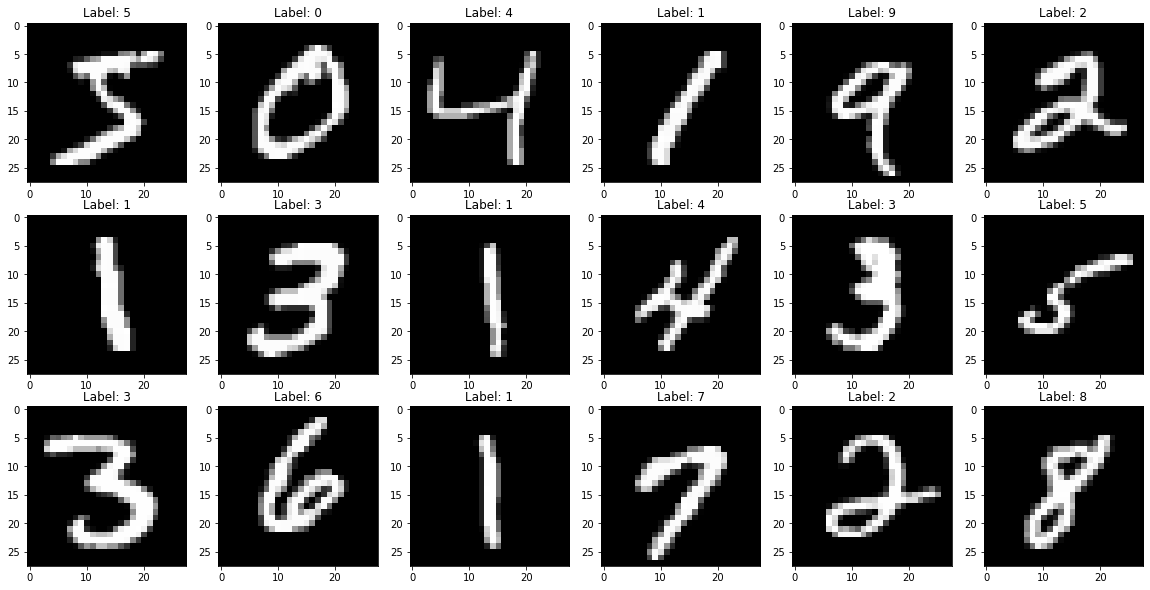

In [50]:
plot_mnist(data=mnist_train)

이처럼 mnist 데이터는 feature data로 손글씨 이미지가 있고 그에 맞게 label data가 있습니다. 

그럼 DataLoader를 통해 batch size를 64로 지정하겠습니다. drop_last=True이면 전체 데이터를 배치단위로 묶은 뒤 남은 데이터를 버리게 됩니다. 

In [51]:
train_loader = DataLoader(dataset=mnist_train, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=64, shuffle=False, drop_last=True)

각 배치의 shape은 64x1x28x28인 feature data와 64개의 label data로 이뤄져 있고 총 937의 배치가 만들어졌습니다. 

In [52]:
for i, batch in enumerate(train_loader):
    x, y = batch
    if i == 0:
        print(x.shape)
        print(y)
print(i+1)

torch.Size([64, 1, 28, 28])
tensor([3, 2, 7, 0, 7, 4, 0, 3, 8, 2, 6, 9, 5, 5, 7, 2, 6, 8, 0, 9, 2, 4, 6, 9,
        6, 1, 2, 0, 8, 0, 0, 4, 8, 0, 7, 4, 8, 1, 5, 7, 4, 3, 1, 0, 8, 5, 4, 7,
        9, 3, 4, 3, 8, 9, 1, 2, 0, 0, 9, 1, 6, 0, 8, 3])
937


In [53]:
len(train_loader)

937

## 모델 구현

기본적인 mlp 모델을 구현해보겠습니다. 2차원 input데이터를 Flatten()을 통해 1차원 행렬로 변환 후 2개의 은닉층을 거쳐 10개의 값을 출력하는 모델을 만듭니다. 

In [54]:
class LionMNISTClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

In [55]:
mlp = LionMNISTClassifier().to(device) # 모델을 gpu에서 계산할 수 있도록 지정
mlp

LionMNISTClassifier(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)

loss 함수는 CrossEntropy, optimizer는 SGD, learning rate는 0.001을 사용합니다

In [56]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(mlp.parameters(), lr=0.001)

## Train

train 과정에서 가장 핵심인 부분은 loss.backward(), optim.step(), optim.zero_grad()로 이어지는 3단계입니다.

- loss.backward()

계산된 loss 텐서에 .backward()를 실행하면 역전파가 실행됩니다. loss 안에 pred의 각 parameters에 대한 변화도를 계산하고 저장합니다.

- optim.step()

저장된 변화도에 따라 각 parameters를 조정합니다.

- optim.zero_grad()

각 parameters에 저장된 변화도를 0으로 초기화합니다. 초기화하지 않으면 변화도가 누적되어 계산됩니다.

In [57]:
num_epochs = 20
train_history = {"loss": [], "acc": []}
for e in range(num_epochs):
    print(f"Epoch: {e} start.")
    epoch_loss, epoch_acc = 0, 0
    size = len(train_loader.dataset)
    for b, (x, y) in enumerate(train_loader):
        x.to(device)
        y.to(device)

        pred = mlp(x)
        loss = loss_fn(pred, y)

        optim.zero_grad() # parameters의 변화량을 0으로 초기화
        loss.backward() # 에러의 변화도를 계산하여 저장
        optim.step() # loss를 최소화 할 수 있도록 parameters 수정

        loss = loss.to("cpu").item()
        acc = (pred.argmax(1) == y).type(torch.float).to("cpu").mean().item()

        if b % 200 == 0:
            print(f"loss: {loss:>7f}, acc: {acc:>4f} [{b * len(x)}/{size}]")

        epoch_loss += loss
        epoch_acc += acc

    train_history["loss"].append(epoch_loss / len(train_loader))
    train_history["acc"].append(epoch_acc / len(train_loader))

Epoch: 0 start.
loss: 2.301665, acc: 0.125000 [0/60000]
loss: 2.298249, acc: 0.140625 [12800/60000]
loss: 2.289978, acc: 0.156250 [25600/60000]
loss: 2.298832, acc: 0.125000 [38400/60000]
loss: 2.285133, acc: 0.187500 [51200/60000]
Epoch: 1 start.
loss: 2.271877, acc: 0.171875 [0/60000]
loss: 2.272564, acc: 0.203125 [12800/60000]
loss: 2.262104, acc: 0.328125 [25600/60000]
loss: 2.254567, acc: 0.343750 [38400/60000]
loss: 2.245733, acc: 0.375000 [51200/60000]
Epoch: 2 start.
loss: 2.232089, acc: 0.421875 [0/60000]
loss: 2.229807, acc: 0.343750 [12800/60000]
loss: 2.220742, acc: 0.437500 [25600/60000]
loss: 2.202565, acc: 0.437500 [38400/60000]
loss: 2.174781, acc: 0.500000 [51200/60000]
Epoch: 3 start.
loss: 2.182073, acc: 0.468750 [0/60000]
loss: 2.145297, acc: 0.531250 [12800/60000]
loss: 2.154594, acc: 0.609375 [25600/60000]
loss: 2.118204, acc: 0.593750 [38400/60000]
loss: 2.096947, acc: 0.625000 [51200/60000]
Epoch: 4 start.
loss: 2.013472, acc: 0.781250 [0/60000]
loss: 1.970716, 

훈련이 진행될수록 loss는 감소하고 정확도는 증가했습니다.

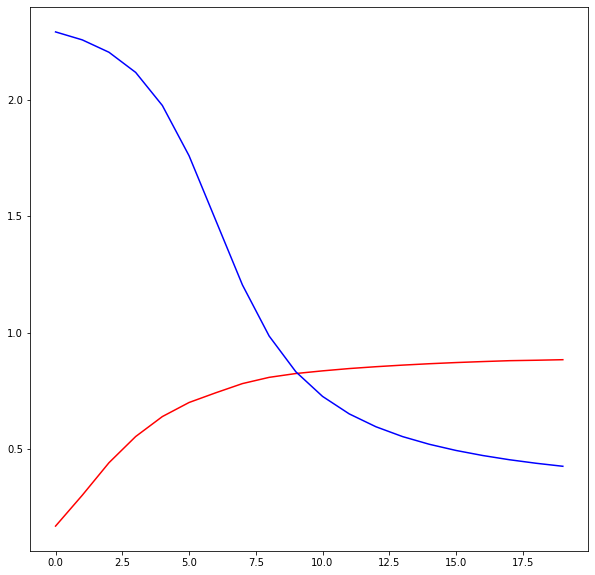

In [58]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_history["acc"], color="red", label="acc")
ax.plot(train_history["loss"], color="blue", label="loss")
fig.show()

## Test

train을 통해 최적화된 model로 test data를 예측합니다. 여기서 with torch.no_grad()문 안에서 실행되는 pytorch는 autograd engine 기능을 중단합니다. 이를 통해 모델의 parameters가 변화하는 것을 방지 할 수 있고 메모리 사용량을 줄이고 연산속도을 높일 수 있습니다.

In [59]:
print("Test start.")
test_loss, test_acc = 0, 0
size = len(test_loader.dataset)

with torch.no_grad():
  for b, (x, y) in enumerate(test_loader):
    x.to(device)
    y.to(device)

    pred = mlp(x)
    test_loss += loss_fn(pred, y).to("cpu").item()
    test_acc += (pred.argmax(1) == y).type(torch.float).to("cpu").mean().item()

  test_loss /= len(test_loader)
  test_acc /= len(test_loader)

print(f"test loss: {test_loss:>7f}, test_acc: {test_acc:>4f}.")

Test start.
test loss: 0.402571, test_acc: 0.890825.


지금까지는 각 노드의 parameters를 최적화하여 모델의 성능을 높였습니다. 하지만 모델의 성능을 높이기 위해 optimizer, lr scheduler, regularization, dropout과 batch normalization 등을 적용할 수 있습니다. 

## split train vaild

In [60]:
class mnist_dataset(Dataset):
  def __init__(self, data, targets, transform=None, target_transform=None):
    super().__init__()

    self.data = data
    self.targets = targets
    self.transform = transform
    self.target_transform = target_transform
    pass

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    x, y = self.data[idx], self.targets[idx]

    if self.transform:
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)

    return x, y

def split_train_valid(dataset, valid_ratio=0.1):
  n_valid = int(len(dataset) * valid_ratio)
  
  train_data = dataset.data[:-n_valid].numpy()
  valid_data = dataset.data[-n_valid:].numpy()
  train_targets = dataset.targets[:-n_valid]
  valid_targets = dataset.targets[-n_valid:]

  train = mnist_dataset(data=train_data, targets=train_targets, transform=dataset.transform, target_transform=dataset.target_transform)
  valid = mnist_dataset(data=valid_data, targets=valid_targets, transform=dataset.transform, target_transform=dataset.target_transform)

  return train, valid

In [61]:
mnist_train, mnist_valid = split_train_valid(dataset=mnist_train)

In [62]:
train_loader = DataLoader(dataset=mnist_train, batch_size= 64, shuffle = True, drop_last=True)
valid_loader = DataLoader(dataset=mnist_valid, batch_size= 64, shuffle = False, drop_last=True)
test_loader = DataLoader(dataset=mnist_test, batch_size= 64, shuffle = False, drop_last=True)

loaders = {
    'train' : train_loader,
    'valid' : valid_loader,
    'test' : test_loader
}

## Trainer class 구현

### _ _ init _ _ ()
model, train/valid/test로 나눠진 dataloder, optimizer 함수, learning rate,  learning rate scheduler 사용 여부를 받아서 정의합니다.

###  _get_optimizer()
optimizer 함수를 정의합니다.

### _get_scheduler()
 learning rate scheduler를 정의합니다. .StepLR()는 일정한 Step 마다 learning rate에 gamma를 곱해주는 방식입니다.

 

In [64]:
class Trainer(nn.Module):
  def __init__(self, model_class, loaders, n_class=10, opt="sgd", lr=0.001, has_scheduler=False, device="cpu"):
    super().__init__()

    self.model = model_class(n_class=n_class)
    self.loss = nn.CrossEntropyLoss()
    
    self.train_loader = loaders["train"]
    self.valid_loader = loaders["valid"]
    self.test_loader = loaders["test"]

    self._get_optimizer(opt=opt.lower(), lr=lr)
    self.has_scheduler = has_scheduler
    if self.has_scheduler:
      self._get_scheduler()

    self.device = device
    pass

  def _get_optimizer(self, opt, lr=0.001):
    if opt == "sgd":
      self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
    elif opt == "adam":
      self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
    else:
      raise ValueError(f"optimizer {opt} is not supproted")

  def _get_scheduler(self):
    self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)

  def train(self, max_epochs=10):
    print("===== Train Start =====")
    history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
    for e in range(max_epochs):
      train_loss, train_acc = self._train_epoch()
      valid_loss, valid_acc = self._valid_epoch()

      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["valid_loss"].append(valid_loss)
      history["valid_acc"].append(valid_acc)

      if self.has_scheduler:
        self.scheduler.step()

      if e % 5 == 0:
        print(f"Epoch: {e}, train loss: {train_loss:>6f}, train acc: {train_acc:>3f}, valid loss: {valid_loss:>6f}, valid acc: {valid_acc:>3f}")

    self.plot_history(history)

  def _train_epoch(self):
    epoch_loss, epoch_acc = 0, 0
    self.model.train()
    for (x, y) in self.train_loader:
      x = x.to(self.device)
      y = y.to(self.device)

      y_hat = self.model(x)
      loss = self.loss(y_hat, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      epoch_loss += loss.to("cpu").item()
      epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(self.train_loader)
    epoch_acc /= len(self.train_loader)

    return epoch_loss, epoch_acc
  
  def _valid_epoch(self):
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()
    with torch.no_grad():
      for (x, y) in self.valid_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(self.valid_loader)
    epoch_acc /= len(self.valid_loader)

    return epoch_loss, epoch_acc

  def plot_history(self, history):
    fig = plt.figure(figsize=(20, 10))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history["train_loss"], color="red", label="train loss")
    ax.plot(history["valid_loss"], color="blue", label="valid loss")
    ax.set_title("Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history["train_acc"], color="red", label="train acc")
    ax.plot(history["valid_acc"], color="blue", label="valid acc")
    ax.set_title("Acc")
    ax.legend()

    fig.show()

  def test(self):
    print("===== Test Start =====")
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()
    with torch.no_grad():
      for (x, y) in self.test_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(self.test_loader)
    epoch_acc /= len(self.test_loader)

    print(f"Test loss: {epoch_loss:>6f}, Test acc: {epoch_acc:>3f}")

## opimizer 비교 (sgd, adam)

===== Train Start =====
Epoch: 0, train loss: 2.295553, train acc: 0.106817, valid loss: 2.283087, valid acc: 0.132056
Epoch: 5, train loss: 1.947945, train acc: 0.604259, valid loss: 1.842954, valid acc: 0.651714
Epoch: 10, train loss: 0.896081, train acc: 0.794614, valid loss: 0.773097, valid acc: 0.834173
Epoch: 15, train loss: 0.572712, train acc: 0.851108, valid loss: 0.481639, valid acc: 0.885249
Epoch: 20, train loss: 0.463532, train acc: 0.873740, valid loss: 0.382930, valid acc: 0.902554
Epoch: 25, train loss: 0.410065, train acc: 0.886937, valid loss: 0.336918, valid acc: 0.907930
Epoch: 30, train loss: 0.377369, train acc: 0.894369, valid loss: 0.309275, valid acc: 0.913474
Epoch: 35, train loss: 0.354613, train acc: 0.900189, valid loss: 0.289848, valid acc: 0.920027
Epoch: 40, train loss: 0.337445, train acc: 0.904100, valid loss: 0.275354, valid acc: 0.922379
Epoch: 45, train loss: 0.323164, train acc: 0.907677, valid loss: 0.263983, valid acc: 0.925235
===== Test Start =

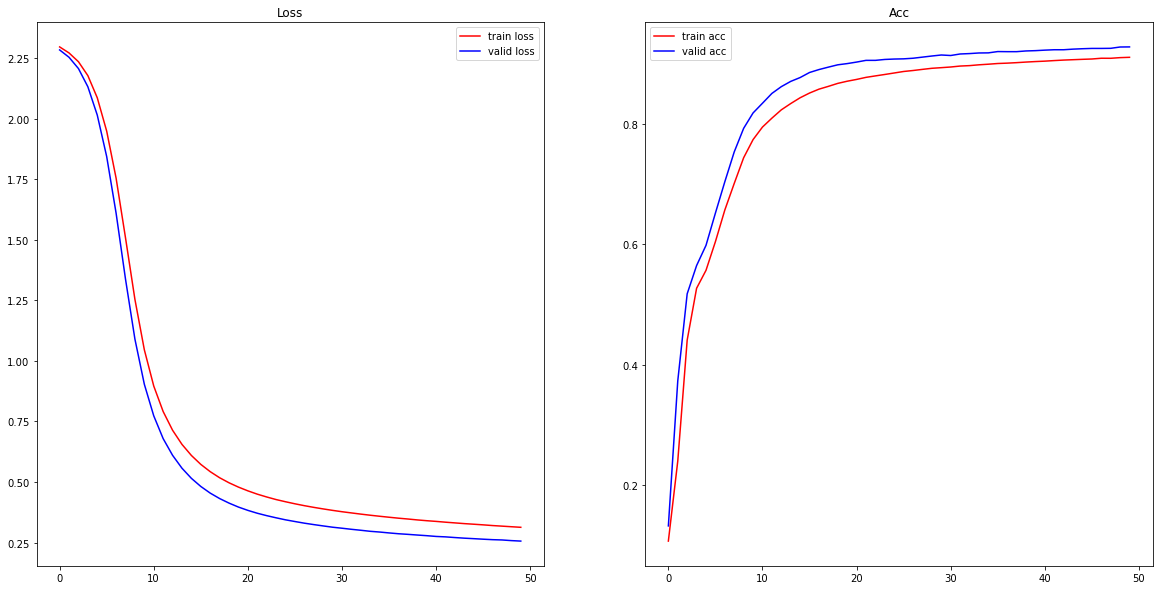

In [65]:
trainer = Trainer(model_class=LionMNISTClassifier, loaders=loaders, n_class=10, opt="sgd", lr=0.001, device=device).to(device)
trainer.train(max_epochs=50)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.311595, train acc: 0.909253, valid loss: 0.119520, valid acc: 0.965726
Epoch: 5, train loss: 0.031945, train acc: 0.989565, valid loss: 0.069239, valid acc: 0.980175
Epoch: 10, train loss: 0.013790, train acc: 0.995199, valid loss: 0.112504, valid acc: 0.977991
Epoch: 15, train loss: 0.010607, train acc: 0.996682, valid loss: 0.102850, valid acc: 0.981183
Epoch: 20, train loss: 0.009770, train acc: 0.996775, valid loss: 0.121291, valid acc: 0.979167
Epoch: 25, train loss: 0.008108, train acc: 0.997535, valid loss: 0.148122, valid acc: 0.979671
Epoch: 30, train loss: 0.007677, train acc: 0.997609, valid loss: 0.122379, valid acc: 0.980847
Epoch: 35, train loss: 0.007524, train acc: 0.997646, valid loss: 0.140478, valid acc: 0.981183
Epoch: 40, train loss: 0.008012, train acc: 0.997479, valid loss: 0.161076, valid acc: 0.981687
Epoch: 45, train loss: 0.002788, train acc: 0.998999, valid loss: 0.153028, valid acc: 0.981687
===== Test Start =

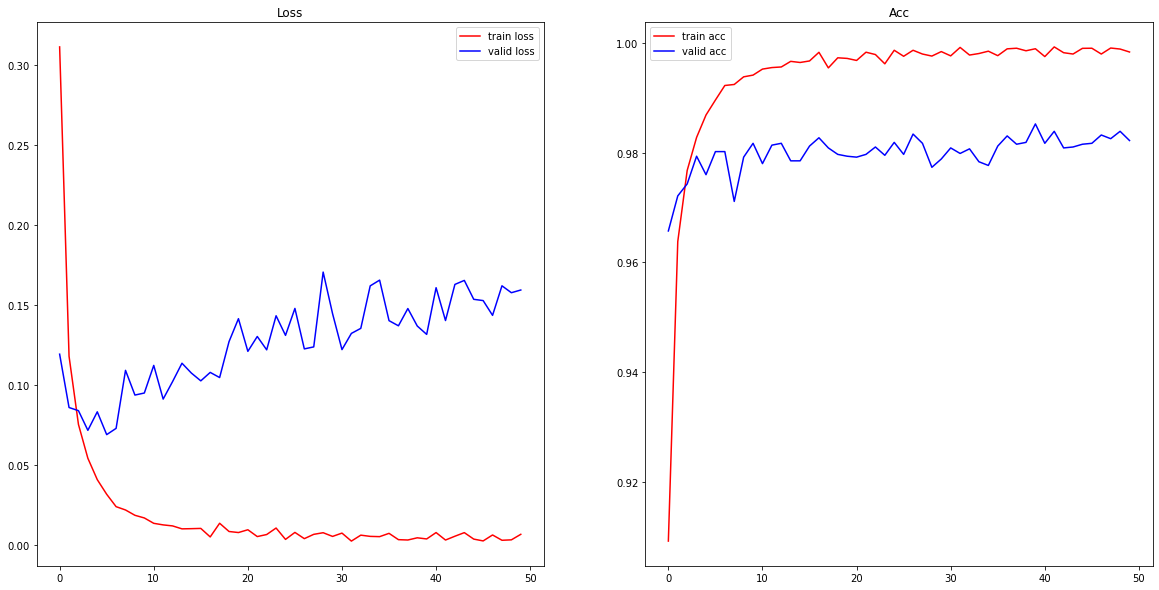

In [66]:
trainer = Trainer(model_class=LionMNISTClassifier, loaders=loaders, n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=50)
trainer.test()

## learning rate scheduler 사용 유무 비교

Adjusting learning rate of group 0 to 1.0000e-03.
===== Train Start =====
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 0, train loss: 0.298859, train acc: 0.912515, valid loss: 0.113368, valid acc: 0.967910
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Epoch: 5, train loss: 0.019372, train acc: 0.994143, valid loss: 0.074378, valid acc: 0.980847
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Epoch: 10, train loss: 0.002533, train acc: 0.999648, valid loss: 0.073066, valid acc: 0.985215
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.

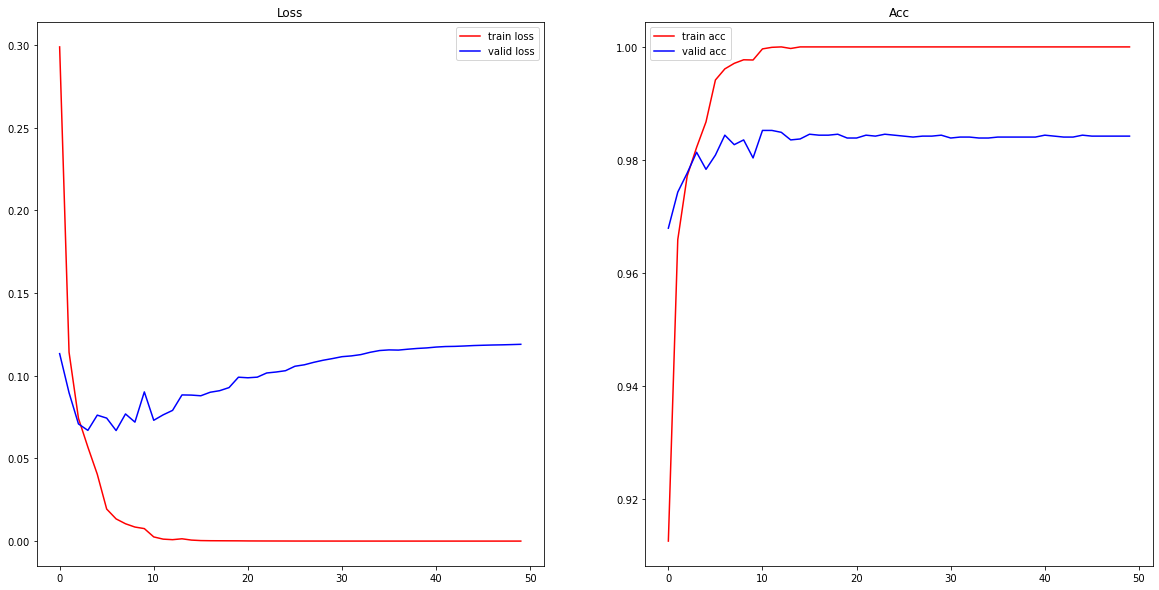

In [67]:
trainer = Trainer(model_class=LionMNISTClassifier, loaders=loaders, n_class=10, opt="adam", lr=0.001, has_scheduler=True, device=device).to(device)
trainer.train(max_epochs=50)
trainer.test()

Adjusting learning rate of group 0 to 1.0000e-03.
===== Train Start =====
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 0, train loss: 0.305770, train acc: 0.910773, valid loss: 0.126068, valid acc: 0.962534
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Epoch: 5, train loss: 0.021139, train acc: 0.994032, valid loss: 0.069836, valid acc: 0.981015
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Epoch: 10, train loss: 0.003273, train acc: 0.999425, valid loss: 0.076760, valid acc: 0.982695
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.

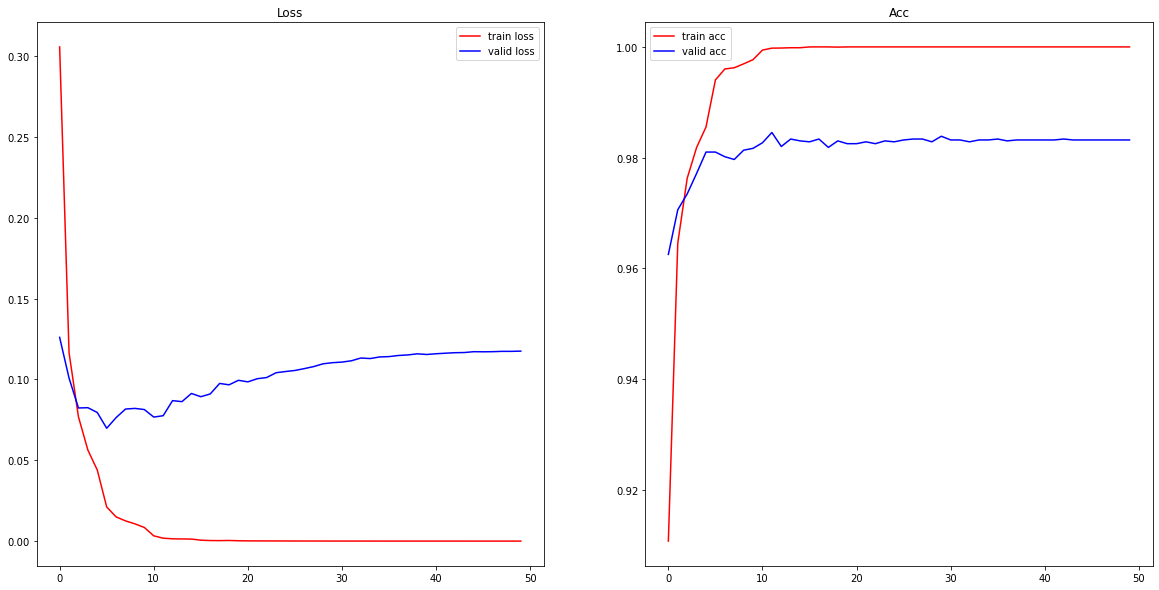

In [68]:
trainer = Trainer(model_class=LionMNISTClassifier, loaders=loaders, n_class=10, opt="adam", lr=0.001, has_scheduler=True, device=device).to(device)
trainer.train(max_epochs=50)
trainer.test()

In [73]:
class LionMNISTDropoutClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

class LionMNISTBNClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

class LionMNISTDropoutBNClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

===== Train Start =====
Epoch: 0, train loss: 0.474353, train acc: 0.856391, valid loss: 0.133085, valid acc: 0.959845
Epoch: 5, train loss: 0.129660, train acc: 0.961466, valid loss: 0.071509, valid acc: 0.978999
Epoch: 10, train loss: 0.101348, train acc: 0.968268, valid loss: 0.059618, valid acc: 0.984039
Epoch: 15, train loss: 0.087402, train acc: 0.972995, valid loss: 0.066591, valid acc: 0.980847
Epoch: 20, train loss: 0.076864, train acc: 0.976535, valid loss: 0.064668, valid acc: 0.982695
Epoch: 25, train loss: 0.070506, train acc: 0.977332, valid loss: 0.062837, valid acc: 0.983031
===== Test Start =====
Test loss: 0.071274, Test acc: 0.982171


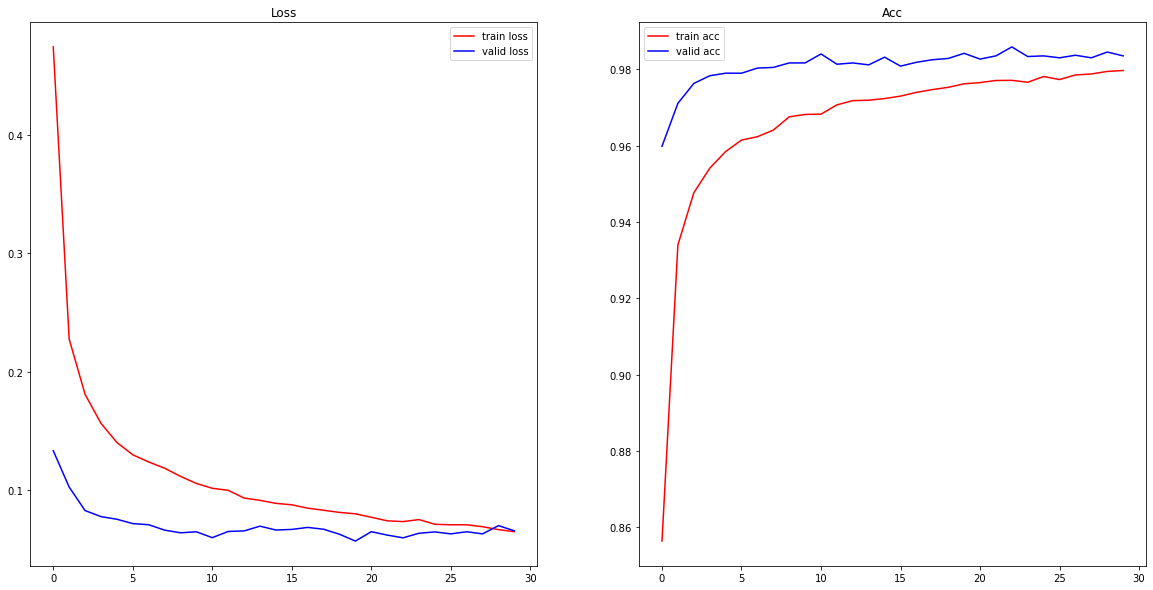

In [70]:
trainer = Trainer(model_class=LionMNISTDropoutClassifier, loaders=loaders, n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

In [72]:
trainer = Trainer(model_class=LionMNISTBNClassifier, loaders=loaders, n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.218458, train acc: 0.939872, valid loss: 0.090992, valid acc: 0.973454
Epoch: 5, train loss: 0.030746, train acc: 0.990195, valid loss: 0.071883, valid acc: 0.980175
Epoch: 10, train loss: 0.016639, train acc: 0.994236, valid loss: 0.072231, valid acc: 0.981183


KeyboardInterrupt: 

In [74]:
trainer = Trainer(model_class=LionMNISTDropoutBNClassifier, loaders=loaders, n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.437250, train acc: 0.875853, valid loss: 0.121283, valid acc: 0.965222
Epoch: 5, train loss: 0.153077, train acc: 0.953607, valid loss: 0.065863, valid acc: 0.981519
Epoch: 10, train loss: 0.116736, train acc: 0.963783, valid loss: 0.060565, valid acc: 0.981687
Epoch: 15, train loss: 0.101321, train acc: 0.968713, valid loss: 0.055470, valid acc: 0.985047
Epoch: 20, train loss: 0.091798, train acc: 0.971438, valid loss: 0.057852, valid acc: 0.983031
